In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pathlib
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

2024-05-14 09:49:17.723797: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 09:49:17.724318: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 09:49:17.727518: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 09:49:17.767634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 09:49:18.428658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
# 데이터 로드 및 전처리 함수 정의
def preprocess_data(data_path, num_mfcc=100, n_fft=2048, hop_length=512, max_pad_len=87):
    # 음성 데이터 불러오기
    y, sr = librosa.load(data_path)  # 오디오 데이터 로드
    
    # MFCC 추출
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    
    # 패딩 적용
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')  # 패딩
    
    return mfccs

In [3]:
# 데이터셋 경로 설정
DATASET_PATH = 'training_data/train_sound'
data_dir = pathlib.Path(DATASET_PATH)
labels = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d != '.ipynb_checkpoints']

print('Filtered Labels:', labels)

Filtered Labels: ['CARSTOP', 'SHOUT', 'EMERGENCY', 'CARBBANG', 'FASTEMERGENCY', 'FIRE', 'GAS', 'STEALSOUND']


In [4]:
# 데이터셋 로드 및 전처리
X = []
y = []
file_labels = []  # 파일명과 레이블 정보를 저장

for label in labels:
    files = os.listdir(os.path.join(data_dir, label))
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(data_dir, label, file)
            try:
                mfccs = preprocess_data(path, max_pad_len=87)  # 패딩의 최대 길이 설정
                X.append(mfccs)
                y.append(file)  # 파일명을 저장
                file_labels.append((file, label))  # 파일명과 레이블을 함께 저장
            except Exception as e:
                print(f"Error processing file {path}: {e}")

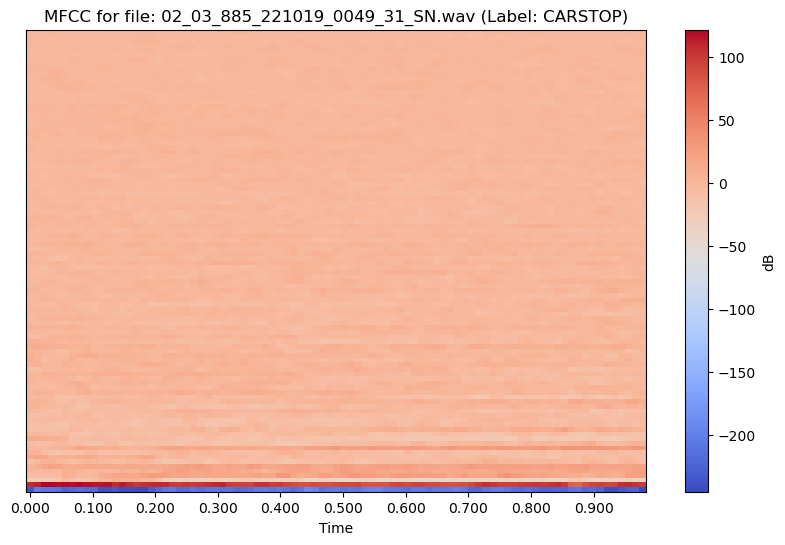

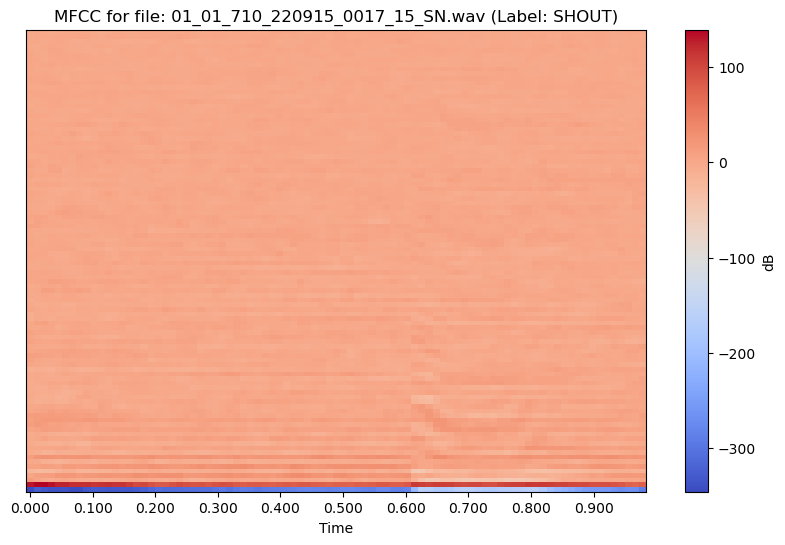

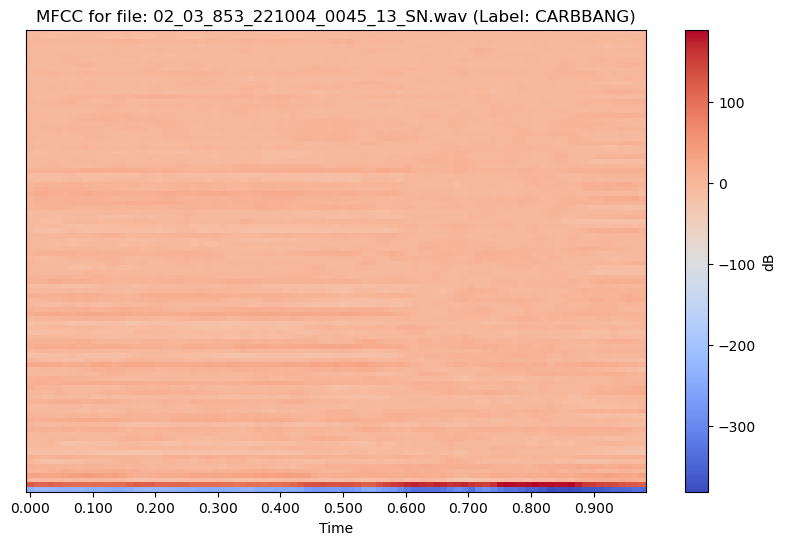

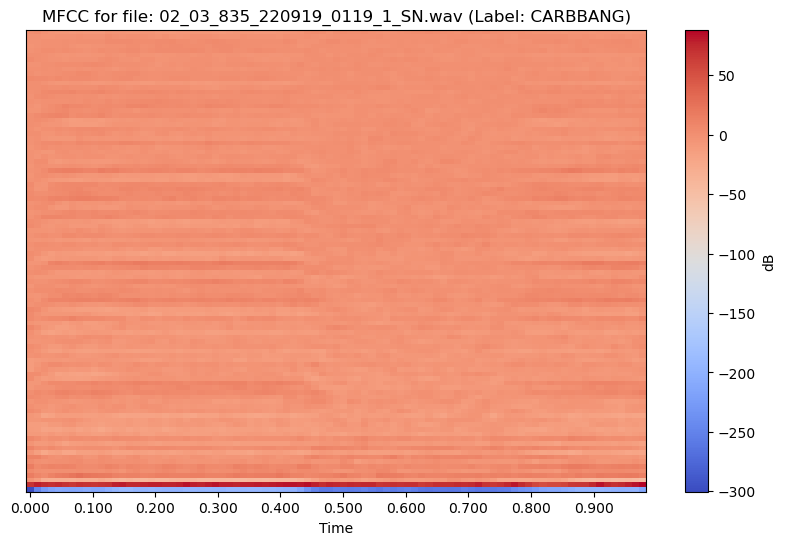

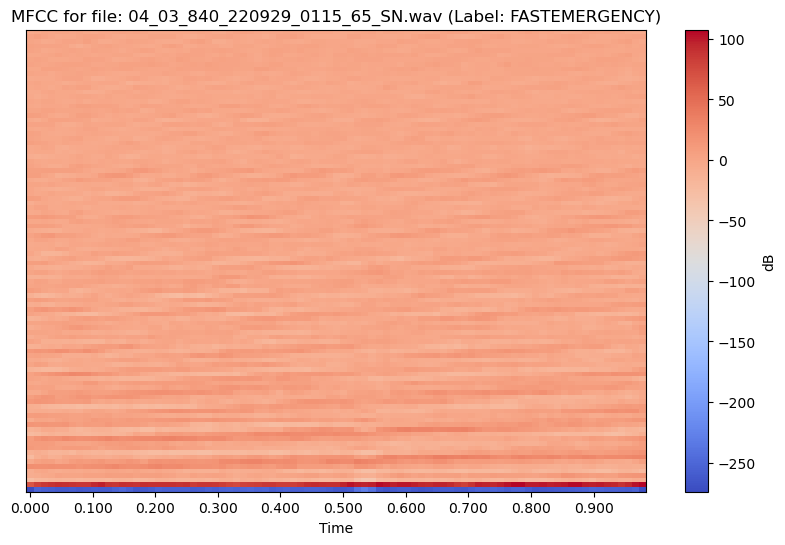

In [5]:
# 랜덤으로 5개 선택하여 시각화
random_indices = np.random.choice(len(X), 5, replace=False)

for idx in random_indices:
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(X[idx], x_axis='time', sr=45000)  # 시간 축을 정확하게 표시
    plt.colorbar(label='dB')
    file_name, file_label = file_labels[idx]  # 파일명과 레이블 정보
    plt.title(f'MFCC for file: {file_name} (Label: {file_label})')  # 파일명과 레이블을 제목으로 표시
    plt.show()

In [6]:
# 데이터셋 변환 및 분할
X = np.array(X)
X = X[..., np.newaxis]  # 차원 확장
y_encoded = to_categorical(LabelEncoder().fit_transform([lbl[1] for lbl in file_labels]))  # 레이블 인코딩

# 80:20 비율로 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [7]:
# CNN 모델 정의
model = Sequential([
    Input(shape=(100, 87, 1)),  # 정확한 입력 shape
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),  # 배치 정규화
    MaxPooling2D(pool_size=(2, 2)),  # 공간 축소
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),  # 공간 축소
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),  # 공간 축소
    Flatten(),  # 차원 평탄화
    Dense(256, activation='relu'),  # 예상 입력 크기
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')  # 출력 클래스 수
])


2024-05-14 09:50:27.578833: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
# 학습률 감소와 얼리 스토핑 콜백
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, batch_size=128, epochs=300, validation_data=(X_test, y_test), callbacks=callbacks)


Epoch 1/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.3558 - loss: 2.8406 - val_accuracy: 0.5210 - val_loss: 1.2506 - learning_rate: 0.0010
Epoch 2/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.7015 - loss: 0.8942 - val_accuracy: 0.6547 - val_loss: 0.9883 - learning_rate: 0.0010
Epoch 3/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.7864 - loss: 0.6308 - val_accuracy: 0.8695 - val_loss: 0.6216 - learning_rate: 0.0010
Epoch 4/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.8309 - loss: 0.5196 - val_accuracy: 0.9066 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 5/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.8690 - loss: 0.3915 - val_accuracy: 0.9230 - val_loss: 0.2771 - learning_rate: 0.0010
Epoch 6/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.8846 - loss: 0.3320 - val_accuracy: 0.9407 - val_loss: 0.1840 - learning_rate: 0.0010
Epoch 7/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.8991 - l

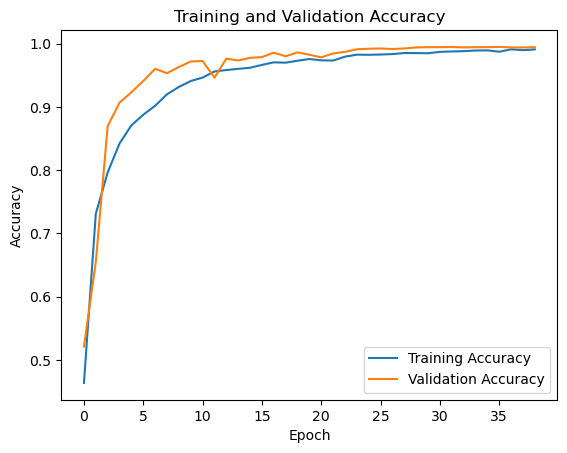

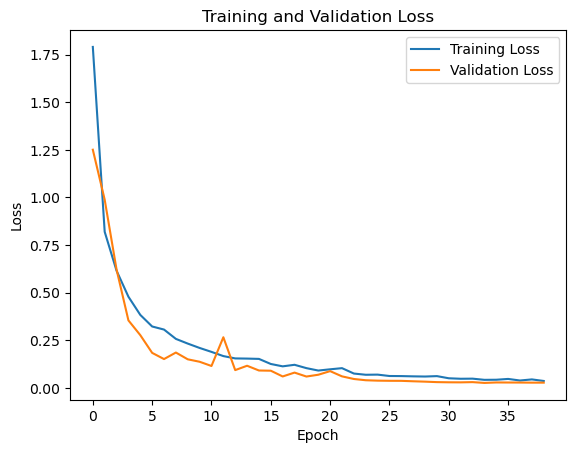

In [9]:
# 학습 정확도 및 검증 정확도 그래프 그리기
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 학습 손실 및 검증 손실 그래프 그리기
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


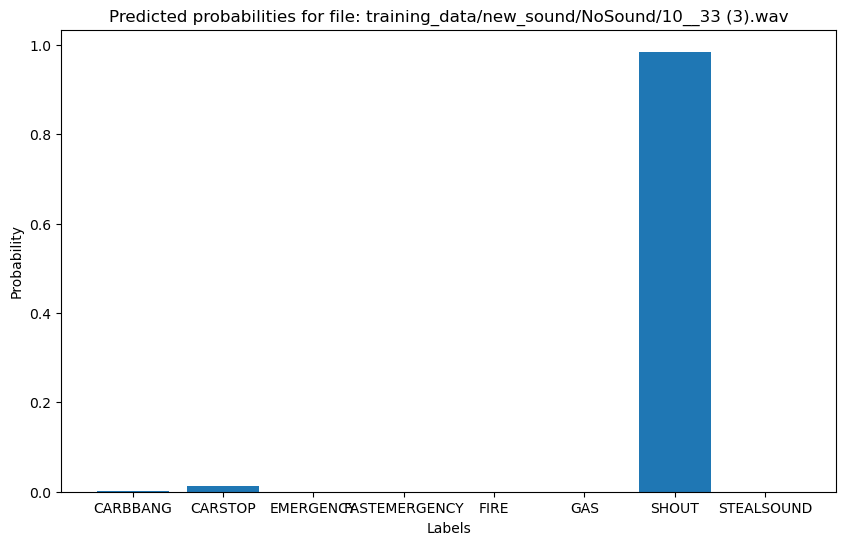

Predicted label: SHOUT


In [10]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import pathlib
import os

# 데이터 로드 및 전처리 함수
def preprocess_test_data(data_path, num_mfcc=100, n_fft=2048, hop_length=512, max_pad_len=87):
    # 음성 데이터 불러오기
    y, sr = librosa.load(data_path)  # 오디오 데이터 로드
    
    # MFCC 추출
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    
    # 패딩 적용
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')  # 패딩
    
    return mfccs[..., np.newaxis]  # 마지막 차원 추가

# 모델 로드
#MODEL_SAVE_PATH = 'model/2024_05_02.h5'
#model = load_model(MODEL_SAVE_PATH)

# 레이블 로드 (학습된 데이터셋의 레이블)
#DATASET_PATH = 'training_data/new_sound/FIRE/01_03_709_220915_0022_11_SN.wav'
#data_dir = pathlib.Path(DATASET_PATH)
labels = ['CARBBANG', 'CARSTOP', 'EMERGENCY', 'FASTEMERGENCY', 'FIRE', 'GAS', 'SHOUT', 'STEALSOUND']
#labels = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d != '.ipynb_checkpoints']

# LabelEncoder 초기화
le = LabelEncoder()
le.fit(labels)

# 테스트할 .wav 파일 경로
TEST_WAV_PATH = 'training_data/new_sound/NoSound/10__33 (3).wav'  # 테스트할 파일 경로로 변경

# 테스트 데이터 전처리
test_mfcc = preprocess_test_data(TEST_WAV_PATH, max_pad_len=87)

# 모델을 통해 예측
predictions = model.predict(np.array([test_mfcc]))  # 입력 데이터 차원 추가
predicted_probabilities = predictions[0]

# 가장 높은 확률의 레이블 예측
predicted_label = le.inverse_transform([np.argmax(predictions)])[0]

# 예측 결과 확률 막대그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(labels, predicted_probabilities)
plt.title(f'Predicted probabilities for file: {TEST_WAV_PATH}')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.show()

print(f"Predicted label: {predicted_label}")


In [11]:
# 학습된 모델을 저장할 디렉토리 지정
MODEL_SAVE_PATH = 'model/2024_05_14_mfcc_cnn.h5'

# 모델 저장
model.save(MODEL_SAVE_PATH)

print(f"Model saved to: {MODEL_SAVE_PATH}")

Model saved to: model/2024_05_14_mfcc_cnn.h5
